# Parameterized inference from multidimensional data

Kyle Cranmer, Juan Pavez, Gilles Louppe, March 2016.

For the sake of the illustration, we will assume 5-dimensional feature $\mathbf{x}$ generated
from the following process $p_0$:

 - $\mathbf{z} := (z_0, z_1, z_2, z_3, z_4)$, such that 
     $z_0 \sim {\cal N}(\mu=\alpha, \sigma=1)$,
     $z_1 \sim {\cal N}(\mu=\beta, \sigma=3)$,
     $z_2 \sim {\text{Mixture}}(\frac{1}{2}\,{\cal N}(\mu=-2, \sigma=1), \frac{1}{2}\,{\cal N}(\mu=2, \sigma=0.5))$,
     $z_3 \sim {\text{Exponential}(\lambda=3)}$, and
     $z_4 \sim {\text{Exponential}(\lambda=0.5)}$;
   
 - $\mathbf{x} := R  \mathbf{z}$, where $R$ is a fixed semi-positive definite $5 \times 5$ matrix defining a fixed projection of $\mathbf{z}$ into the observed space.
  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

import numpy as np
import theano
from scipy.stats import chi2

In [2]:
from carl.distributions import Join
from carl.distributions import Mixture
from carl.distributions import Normal
from carl.distributions import Exponential
from carl.distributions import LinearTransform
from sklearn.datasets import make_sparse_spd_matrix

# Parameters
true_A = 1.
true_B = -1.
A = theano.shared(true_A, name="A")
B = theano.shared(true_B, name="B")

# Build simulator
R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7)

p0 = LinearTransform(Join(components=[
        Normal(mu=A, sigma=1),
        Normal(mu=B, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

# Define p1 at fixed arbitrary value theta1 := 0,0
p1 = LinearTransform(Join(components=[
        Normal(mu=0, sigma=1),
        Normal(mu=0, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

# Draw data
X_true = p0.rvs(500, random_state=314) 

In [3]:
# Projection operator
print(R)

[[ 1.31229955  0.10499961  0.48310515 -0.3249938  -0.26387927]
 [ 0.10499961  1.15833058 -0.55865473  0.25275522 -0.39790775]
 [ 0.48310515 -0.55865473  2.25874579 -0.52087938 -0.39271231]
 [-0.3249938   0.25275522 -0.52087938  1.4034925  -0.63521059]
 [-0.26387927 -0.39790775 -0.39271231 -0.63521059  1.        ]]


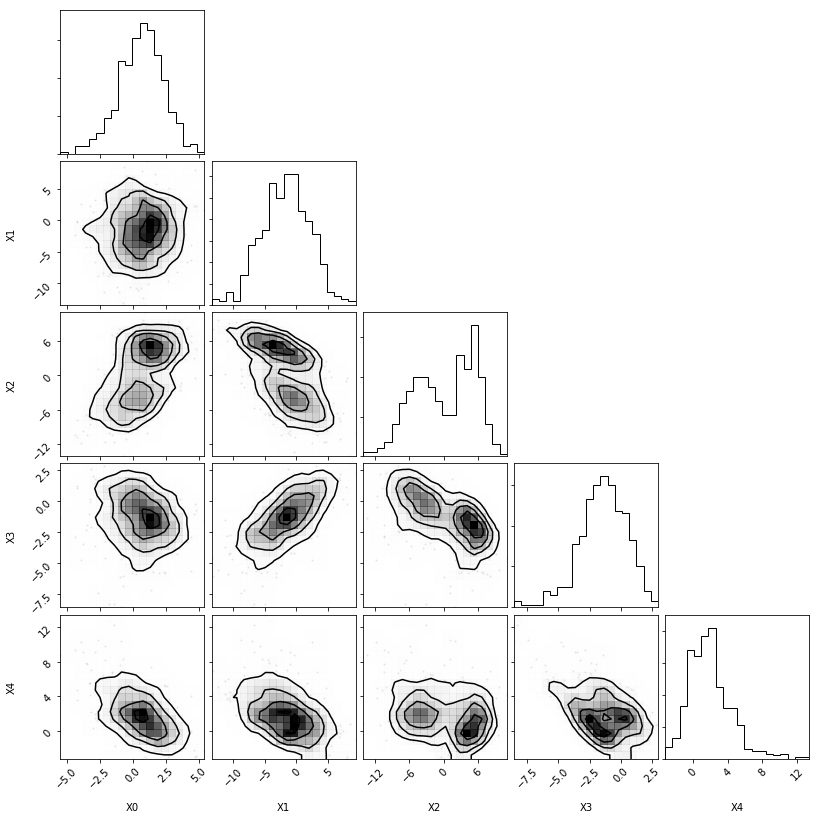

In [4]:
# Plot the data
import corner
fig = corner.corner(X_true, bins=20, smooth=0.85, labels=["X0", "X1", "X2", "X3", "X4"])
#plt.savefig("fig3.pdf")

## Exact likelihood setup

In [5]:
# Minimize the exact LR
from scipy.optimize import minimize

def nll_exact(theta, X):
    A.set_value(theta[0])
    B.set_value(theta[1])
    return (p0.nll(X) - p1.nll(X)).sum()

r = minimize(nll_exact, x0=[0, 0], args=(X_true,))
exact_MLE = r.x

print("Exact MLE =", exact_MLE)

('Exact MLE =', array([ 1.01185167, -0.92213119]))


In [9]:
# Exact contours
A.set_value(true_A)
B.set_value(true_B)

bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16),
          (exact_MLE[1] - 0.5, exact_MLE[1] + 0.5)]

As = np.linspace(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16, 100)
Bs = np.linspace(exact_MLE[1] - 0.5, exact_MLE[1] + 0.5, 100)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1), BB.reshape(-1, 1)))

exact_contours = np.zeros(len(X))

i = 0
for a in As:
    for b in Bs:
        exact_contours[i] = nll_exact([a, b], X_true)
        i += 1
        
exact_contours = 2. * (exact_contours - r.fun)

In [ ]:
plt.contour(As, Bs, exact_contours.reshape(AA.shape).T, 
            levels=[chi2.ppf(0.683, df=2), 
                    chi2.ppf(0.9545, df=2),
                    chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, exact_contours.reshape(AA.shape).T, 50, vmin=0, vmax=30)
cb = plt.colorbar()

plt.plot([true_A], [true_B], "r.", markersize=8)
plt.plot([exact_MLE[0]], [exact_MLE[1]], "g.", markersize=8)
#plt.plot([gp_MLE[0]], [gp_MLE[1]], "b.", markersize=8)

plt.axis((*bounds[0], *bounds[1]))
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")

#plt.savefig("fig4a.pdf")
plt.show()

## Likelihood-free setup

In this example we will build a parametrized classifier $s(x; \theta_0, \theta_1)$ with $\theta_1$ fixed to $(\alpha=0, \beta=0)$.

In [44]:
# Build classification data
from carl.learning import make_parameterized_classification

bounds = [(-3, 3), (-3, 3)]

X, y = make_parameterized_classification(
    p0, p1,
    1000000, 
    [(A, np.linspace(*bounds[0], num=30)), 
     (B, np.linspace(*bounds[1], num=30))],
    random_state=1)

In [ ]:
# Train parameterized classifier
from carl.learning import as_classifier
from carl.learning import make_parameterized_classification
from carl.learning import ParameterizedClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

clf = ParameterizedClassifier(
    make_pipeline(StandardScaler(), 
                  as_classifier(MLPRegressor(learning_rate="adaptive", 
                                             hidden_layer_sizes=(40, 40),
                                             tol=1e-6,
                                             random_state=0))),
    [A, B])
clf.fit(X, y)

For the scans and Bayesian optimization we construct two helper functions.

In [58]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

def objective(theta, random_state=0):    
    print(theta)
    
    # Set parameter values   
    A.set_value(theta[0])
    B.set_value(theta[1])
    
    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=50))

    X0 = p0.rvs(n_samples=250000)
    X1 = p1.rvs(n_samples=250000, random_state=random_state)
    X = np.vstack((X0, X1))
    y = np.zeros(len(X))
    y[len(X0):] = 1

    ratio.fit(X, y)
    
    # Evaluate log-likelihood ratio
    r = ratio.predict(X_true, log=True)
    value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                         # this will need to be rescaled by len(X_true)    
            
    return value

In [ ]:
from GPyOpt.methods import BayesianOptimization
bounds = [(-3, 3), (-3, 3)]
solver = BayesianOptimization(vectorize(objective), bounds)
solver.run_optimization(max_iter=50, true_gradients=False)

In [60]:
approx_MLE = solver.x_opt
print("Approx. MLE =", approx_MLE)

Approx. MLE = [ 1.01455539 -0.90202743]


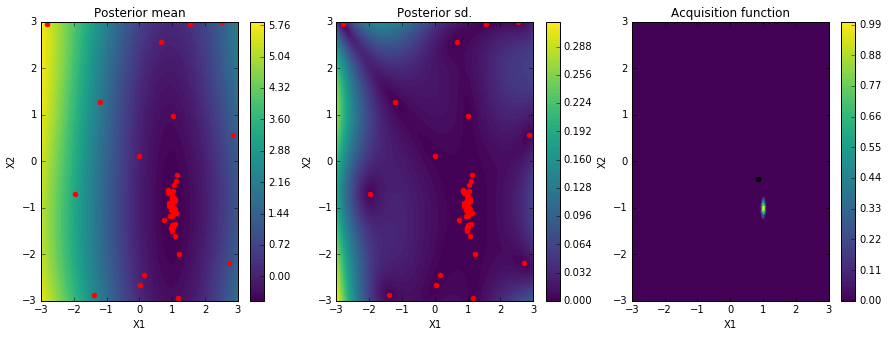

In [61]:
solver.plot_acquisition()

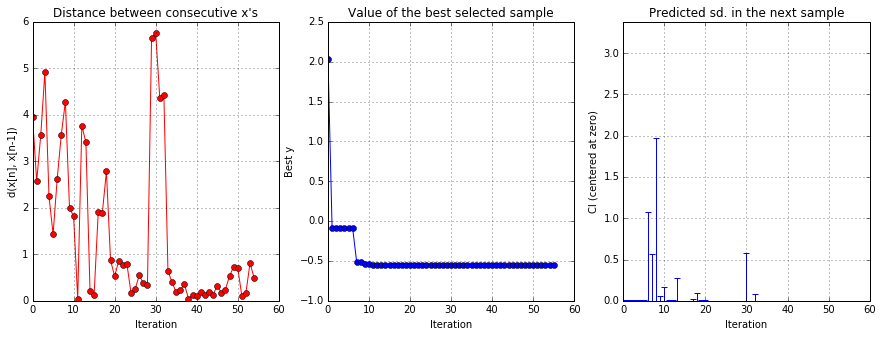

In [62]:
solver.plot_convergence()

In [88]:
# Minimize the surrogate GP approximate of the approximate LR
def gp_objective(theta):
    theta = theta.reshape(1, -1)
    return solver.model.predict(theta)[0][0]

r = minimize(gp_objective, x0=[0, 0])
gp_MLE = r.x

print("GP MLE =", gp_MLE)

GP MLE = [ 1.00846361 -1.00438228]


Here we plot the posterior mean of the Gaussian Process surrogate learned by the Bayesian Optimization algorithm.

In [89]:
# Plot GP contours
A.set_value(true_A)
B.set_value(true_B)

bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16),
          (exact_MLE[1] - 0.5, exact_MLE[1] + 0.5)]

As = np.linspace(*bounds[0], 100)
Bs = np.linspace(*bounds[1], 100)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1), BB.reshape(-1, 1)))

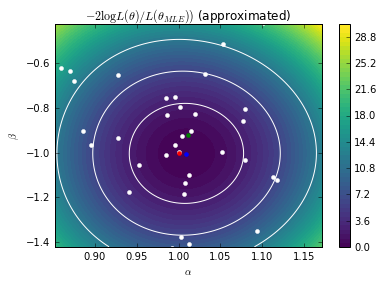

In [92]:
from scipy.stats import chi2
gp_contours, _= solver.model.predict(X)
gp_contours = 2. * (gp_contours - r.fun) * len(X_true)  # Rescale

cs = plt.contour(As, Bs, gp_contours.reshape(AA.shape), 
                 levels=[chi2.ppf(0.683, df=2), 
                         chi2.ppf(0.9545, df=2),
                         chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, gp_contours.reshape(AA.shape), 50, vmin=0, vmax=30)
cb = plt.colorbar()

plt.plot(solver.X[:, 0], solver.X[:, 1], 'w.', markersize=8)
plt.plot([true_A], [true_B], "r.", markersize=8)
plt.plot([exact_MLE[0]], [exact_MLE[1]], "g.", markersize=8)
plt.plot([gp_MLE[0]], [gp_MLE[1]], "b.", markersize=8)

plt.axis((*bounds[0], *bounds[1]))
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")

#plt.savefig("fig4b.pdf")
plt.show()

Finally, we plot the approximate likelihood from a grid scan. Statistical fluctuations in the calibration lead to some noise in the scan. The Gaussian Process surrogate above smooths out this noise providing a smoother approximate likelihood.

In [84]:
# Contours of the approximated LR
A.set_value(true_A)
B.set_value(true_B)

bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16),
          (exact_MLE[1] - 0.5, exact_MLE[1] + 0.5)]

As = np.linspace(*bounds[0], 16)
Bs = np.linspace(*bounds[1], 16)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

In [ ]:
approx_contours = np.zeros(len(X))

i = 0
for a in As:    
    for b in Bs:
        approx_contours[i] = objective([a, b]) 
        i += 1
        
approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)

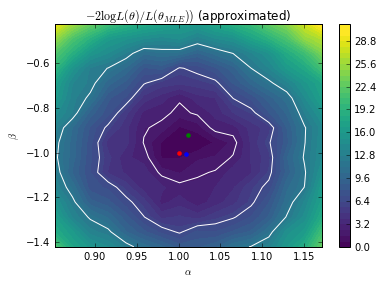

In [87]:
plt.contour(As, Bs, approx_contours.reshape(AA.shape).T, 
            levels=[chi2.ppf(0.683, df=2), 
                    chi2.ppf(0.9545, df=2),
                    chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, approx_contours.reshape(AA.shape).T, 50, vmin=0, vmax=30)
plt.colorbar()

plt.plot([true_A], [true_B], "r.", markersize=8)
plt.plot([exact_MLE[0]], [exact_MLE[1]], "g.", markersize=8)
plt.plot([gp_MLE[0]], [gp_MLE[1]], "b.", markersize=8)

plt.axis((*bounds[0], *bounds[1]))
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")

#plt.savefig("fig4c.pdf")
plt.show()